In [1]:
import pandas as pd
import numpy as np
import sys

from scipy import sparse
from scipy.stats import stats


import wikipedia
from wikipedia import DisambiguationError

from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, ConceptsOptions

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

from fuzzywuzzy import fuzz

from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
sns.set_style('darkgrid')

In [3]:
ibm_creds = {
  "url": "https://gateway.watsonplatform.net/natural-language-understanding/api",
  "username": "bb7a01e4-be21-44f1-83a3-2c316cf57d73",
  "password": "x5LAoqvRykNR"
}
natural_language_understanding = NaturalLanguageUnderstandingV1(
  username=ibm_creds['username'],
  password=ibm_creds['password'],
  version='2017-02-27')

In [17]:
data = pd.read_excel('/Users/alex/Documents/ReadingInsights/library_export.xlsx')
print(data.shape)
print(data.dtypes)
print(data.head())

(51, 37)
book_id                            int64
title                             object
author                            object
inf_north_amer                     int64
inf_south_central_amer             int64
inf_asia                           int64
inf_middle_east                    int64
inf_west_europe                    int64
inf_east_europe                    int64
inf_africa                         int64
inf_oceania                        int64
is_female                          int64
isbn13                           float64
rating                             int64
agg_rating                       float64
pages                              int64
pub_year                           int64
org_pub_year                       int64
finished                  datetime64[ns]
started                   datetime64[ns]
duration                           int64
is_fiction                         int64
is_nonfiction                      int64
is_adventure                       int64
is_biog

In [6]:
authors = data['author']
author_url = {}
try:
    for author in set(authors):
        author_url[author] = wikipedia.page(author).url
except DisambiguationError as err:
    print(err)
    
print(author_url)

{'William Shakespeare': 'https://en.wikipedia.org/wiki/William_Shakespeare', 'Ernest Hemingway': 'https://en.wikipedia.org/wiki/Ernest_Hemingway', 'David Grossman': 'https://en.wikipedia.org/wiki/David_Grossman', 'Epictetus': 'https://en.wikipedia.org/wiki/Epictetus', 'Paul Kalanithi': 'https://en.wikipedia.org/wiki/Paul_Kalanithi', 'Khaled Hosseini': 'https://en.wikipedia.org/wiki/Khaled_Hosseini', 'Czeslaw Milosz': 'https://en.wikipedia.org/wiki/Czes%C5%82aw_Mi%C5%82osz', 'Mitch Albom': 'https://en.wikipedia.org/wiki/Mitch_Albom', 'Dalai Lama XIV': 'https://en.wikipedia.org/wiki/14th_Dalai_Lama', 'Thanissaro Bhikkhu': 'https://en.wikipedia.org/wiki/Thanissaro_Bhikkhu', 'Jim Afremow': 'https://en.wikipedia.org/wiki/Duncan_Armstrong', 'V.S. Ramachandran': 'https://en.wikipedia.org/wiki/Vilayanur_S._Ramachandran', 'Jack Spicer': 'https://en.wikipedia.org/wiki/Jack_Spicer', 'Tom Shroder': 'https://en.wikipedia.org/wiki/Tom_Shroder', 'Zora Neale Hurston': 'https://en.wikipedia.org/wiki/Zo

In [7]:
author_url['Jim Afremow'] = 'http://www.goldmedalmind.net/about-dr-jim/'
author_url['Stefan Hildebrandt'] = 'http://worldcat.org/identities/lccn-n80054555/'
author_url['Russell Wild'] = 'https://www.napfa.org/member/5511/3203'

In [13]:
concepts = {}
for author in author_url:
    response = natural_language_understanding.analyze(
      url=author_url[author],
        language='en',
      features=Features(
        concepts=ConceptsOptions(
        limit=8)))
    concepts[author] = []
    for concept in response['concepts']:
        concepts[author].append(concept['text'])
        

WatsonApiException: Error: attempt to fetch failed: :closed, Code: 400

In [98]:
mixed_concepts = list(chain.from_iterable(concepts.values()))

def find_similarities(arr):
    simplified_concepts = []
    
    for first in arr:
        for second in arr:
            simplest = min([first, second], key=len)
            if first is not second and fuzz.partial_ratio(first, second) > 85 and simplest not in simplified_concepts:
                #print((first, second, simplest))
                simplified_concepts.append(simplest)
                
    return simplified_concepts

a = find_similarities(mixed_concepts)
final_concepts = find_similarities(a)

In [5]:
data_object = data[['title', 'author',  'finished', 'started']]
data_numeric = data[['inf_north_amer', 'inf_south_central_amer', 'inf_asia', 'inf_middle_east',
       'inf_west_europe', 'inf_east_europe', 'inf_africa', 'inf_oceania',
       'is_female', 'agg_rating', 'pages', 'pub_year',
       'org_pub_year', 'duration', 'is_fiction',
       'is_nonfiction', 'is_adventure', 'is_biography', 'is_drama',
       'is_expository', 'is_historical_ficition', 'is_memoir', 'is_philosophy',
       'is_poetry', 'is_political_science', 'is_realistic_fiction',
       'is_religion', 'is_science', 'is_sci_fi', 'is_short_story']]
target = data[['rating']]


In [6]:
print(sys.getsizeof(data_numeric))

sparse_data_numeric = sparse.csr_matrix(data_numeric)

print(sparse_data_numeric.dtype)
print(sys.getsizeof(sparse_data_numeric))

12344
float64
56


In [7]:
scaled_sparse_data_numeric = preprocessing.scale(sparse_data_numeric.toarray(), with_mean=False)

quantile_trans_sparse_data_numeric = preprocessing.quantile_transform(sparse_data_numeric.toarray(), output_distribution='normal')

In [8]:
def find_correlation(df, thresh=0.9):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove
    params:
    - df : pd.DataFrame
    - thresh : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
               
    Created by Scott Warchal
    https://gist.github.com/Swarchal/881976176aaeb21e8e8df486903e99d6
    """
    
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)

    already_in = set()
    result = []

    for col in corrMatrix:
        perfect_corr = corrMatrix[col][corrMatrix[col] > thresh].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)


    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

find_correlation(data_numeric, 0.7)

[]

[ 0.44695147  0.50900105  0.04300303]
[ 0.26530556  0.18297211  0.09910943]


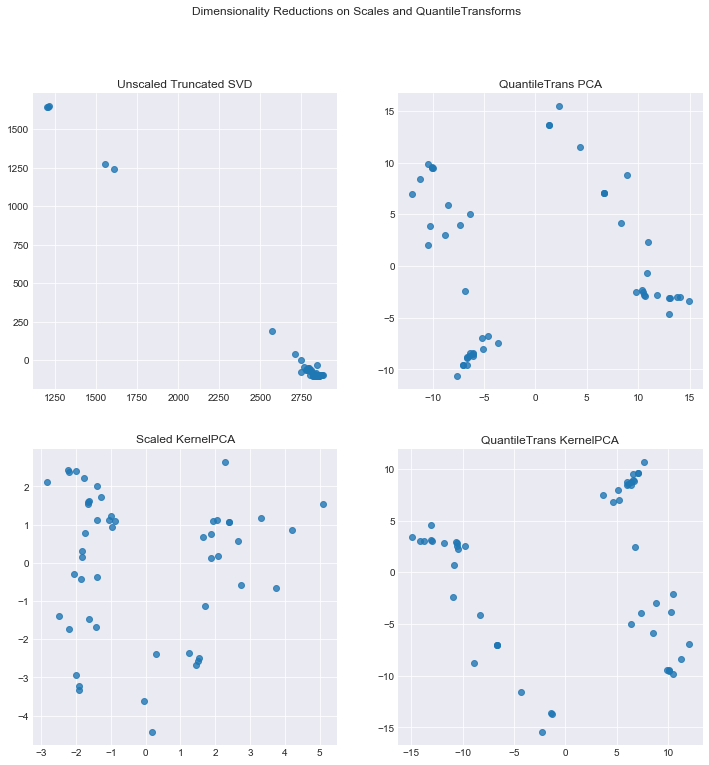

In [9]:
fig = plt.figure(figsize=(12,12))
fig.suptitle("Dimensionality Reductions on Scales and QuantileTransforms")

plt.subplot(2, 2, 1)
plt.title("Unscaled Truncated SVD")

components = 3

tsvd_decomp = TruncatedSVD(n_components=components).fit(sparse_data_numeric)
print(tsvd_decomp.explained_variance_ratio_)
tsvd_decomp = tsvd_decomp.transform(sparse_data_numeric)

a = tsvd_decomp[:,0]
b = tsvd_decomp[:,1]
sns.regplot(a,b, fit_reg=False)

plt.subplot(2, 2, 2)
plt.title("QuantileTrans PCA")

pca_decomp = PCA(n_components=components).fit(quantile_trans_sparse_data_numeric)
print(pca_decomp.explained_variance_ratio_)
pca_decomp = pca_decomp.transform(quantile_trans_sparse_data_numeric)

a = pca_decomp[:,0]
b = pca_decomp[:,1]
sns.regplot(a,b, fit_reg=False)

plt.subplot(2, 2, 3)
plt.title("Scaled KernelPCA")
kpca_s_decomp = KernelPCA(n_components=components).fit_transform(scaled_sparse_data_numeric)

a = kpca_s_decomp[:, 0]
b = kpca_s_decomp[:, 1]
sns.regplot(a,b,fit_reg=False)

plt.subplot(2, 2, 4)
plt.title("QuantileTrans KernelPCA")
kpca_qt_decomp = KernelPCA(n_components=components).fit_transform(quantile_trans_sparse_data_numeric)

a = kpca_qt_decomp[:, 0]
b = kpca_qt_decomp[:, 1]
sns.regplot(a,b,fit_reg=False)

plt.show()


In [11]:
sets = [scaled_sparse_data_numeric, tsvd_decomp, pca_decomp, kpca_s_decomp, kpca_qt_decomp]
sets_labels = ['Scaled Sparse Data', 'Truncated SVD', 'PCA', 'Scaled KernelPCA', 'Quantile Transform KernelPCA']

clfs = [LogisticRegression(), RidgeClassifier(), KNeighborsClassifier(),
        SVC(), SGDClassifier(loss='hinge', max_iter=1000), AdaBoostClassifier(),
        RandomForestClassifier(n_estimators=50)]

score_threshold = 0.5

for i, set in enumerate(sets):
    X_train, X_test, y_train, y_test = train_test_split(
        set, np.array(target).ravel(), test_size=0.25)

    for clf in clfs:
        clf = clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        if score > score_threshold:
            print('{} score for {}:\n\t{:.2f}\tat split {}'.format(clf.__class__.__name__, sets_labels[i], score, 0.25))


AdaBoostClassifier score for Quantile Transform KernelPCA:
	0.54	at split 0.25


In [22]:

X = scaled_sparse_data_numeric
y = np.array(target).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [23]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=2)

for train_index, test_index in skf.split(X_train, y_train):
   print('TRAIN:\t{}\nTEST:\t{}\n'.format(train_index,test_index))
   a, c = X_train[train_index], X_train[test_index]
   b, d = y_train[train_index], y_train[test_index]

(len(train_index), len(b))

TRAIN:	[10 20 22 23 24 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
TEST:	[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 21 25]

TRAIN:	[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 21 25]
TEST:	[10 20 22 23 24 26 27 28 29 30 31 32 33 34 35 36 37 38 39]



(21, 21)

In [24]:
models = {
    'LogisticRegression': LogisticRegression(),
    'RidgeClassifier': RidgeClassifier(),
    'SGDClassifier': SGDClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'GaussianProcessClassifier': GaussianProcessClassifier()
}
params = {
    'LogisticRegression': {
        'C': [0.000000001, 0.000001, 0.00001, 0.001, 0.01, 0.1, 0.5, 1., 2., 10.],
        'penalty': ['l2', 'l1']
    },
    'RidgeClassifier': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 10., 100., 500., 1000.]
    },
    'SGDClassifier': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 10., 100.],
        'max_iter': [500, 1000, 2500],
        'loss': ['hinge', 'squared_hinge'],
        'penalty': ['l2', 'l1']
    },
    'KNeighborsClassifier': {
        'n_neighbors': [2, 3, 4, 6, 8, 10, 12, 14],
        'leaf_size': [3, 6, 10, 20, 30, 40, 50, 60]
    },
    'SVC': {
        'C': [0.000000001, 0.000001, 0.00001, 0.001, 0.01, 0.1, 0.5, 1., 2., 10.],
        'kernel': ['linear', 'rbf'],
        'gamma': ['auto', 0.1, 1., 2., 10.]
    },
    'RandomForestClassifier': {
        'max_features': ['auto', 'log2', 0.25, 0.5, 0.75, 1],
        'n_estimators': [1, 3, 5, 7, 10, 25, 50, 75, 100],
        'max_depth': [3, 5, 7, 10, 20, None]
    },
    'AdaBoostClassifier': {
        'n_estimators': [1, 3, 5, 7, 10, 25, 50, 75, 100]
    },
    'GaussianNB': {
        
    },
    'GaussianProcessClassifier': {
        
    }
}

searches = {}

for key in models.keys():
    gs = GridSearchCV(models[key], params[key], cv=2, return_train_score=True)
    gs.fit(X_train, y_train)
    searches[key] = gs




In [26]:
print('Estimating...\n\n')

def mean_squared_classifier(y_pred, y_true):
    sqr_sum = 0
    for y0, y1 in zip(y_pred, y_true):
        y0 = (y0 - 1)/4
        y1 = (y1 - 1)/4
        
        sqr_sum += pow(y1 - y0, 2)
        
    return 1-sqr_sum/len(y_true)
    
for search in searches:

    clf = models[search]
    clf.set_params(**searches[search].best_params_)
    clf.fit(X_train, y_train)

    print('{}\n{}\n{}\n{}\n{:.4f}\n\n'.format(
        search, 
        '-'*50, 
        clf.predict(X_test),
        y_test,
        mean_squared_classifier(clf.predict(X_test), y_test)))


Estimating...


LogisticRegression
--------------------------------------------------
[4 3 4 5 3 5 5 3 5 5 3]
[4 3 2 4 3 4 5 3 5 4 3]
0.9602


RidgeClassifier
--------------------------------------------------
[4 4 4 4 2 5 5 3 5 5 3]
[4 3 2 4 3 4 5 3 5 4 3]
0.9545


SGDClassifier
--------------------------------------------------
[3 3 3 5 3 5 5 3 5 5 3]
[4 3 2 4 3 4 5 3 5 4 3]
0.9716


KNeighborsClassifier
--------------------------------------------------
[3 3 4 2 2 5 5 2 5 4 3]
[4 3 2 4 3 4 5 3 5 4 3]
0.9318


SVC
--------------------------------------------------
[4 4 4 3 2 5 5 2 5 5 3]
[4 3 2 4 3 4 5 3 5 4 3]
0.9432


RandomForestClassifier
--------------------------------------------------
[3 3 2 3 2 3 4 2 5 5 5]
[4 3 2 4 3 4 5 3 5 4 3]
0.9375


AdaBoostClassifier
--------------------------------------------------
[3 1 4 4 3 4 4 3 4 4 3]
[4 3 2 4 3 4 5 3 5 4 3]
0.9375


GaussianNB
--------------------------------------------------
[4 2 4 3 2 5 5 2 5 5 2]
[4 3 2 4 3 4 5 3 5 4 3]
0.

GaussianProcessClassifier
--------------------------------------------------
[4 3 4 3 2 5 5 3 4 4 4]
[4 3 2 4 3 4 5 3 5 4 3]
0.9489


